In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import yahist
from matplotlib.collections import LineCollection

from utils import load_df_nytimes

In [2]:
yahist.utils.set_default_style()

In [3]:
avg_over = 7
df_counties = load_df_nytimes(counties=True, cases=True, avg_over=avg_over)
df_states = load_df_nytimes(counties=False, cases=True, avg_over=avg_over)

In [4]:
df_states

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-07,42630.857143,1316.571429,94712.000000,23097.428571,263808.285714,33855.285714,46768.285714,11999.285714,10457.571429,188149.285714,...,48881.000000,195927.571429,24568.285714,1237.857143,108.000000,65004.285714,37063.285714,3235.000000,34127.571429,1610.285714
2020-07-08,43773.714286,1359.142857,98220.285714,23675.857143,271885.428571,34165.714286,46844.857143,12135.285714,10497.142857,197404.428571,...,50366.142857,203683.285714,25147.857143,1244.428571,115.714286,65600.285714,37692.285714,3339.000000,34730.285714,1642.571429
2020-07-09,45068.428571,1401.571429,101832.857143,24244.000000,279788.000000,34489.857143,46925.285714,12249.571429,10538.428571,206491.857143,...,51845.428571,211935.428571,25743.000000,1250.857143,122.285714,66207.857143,38327.714286,3449.428571,35370.571429,1674.571429


In [5]:
max_date = str(df_states.index.max()).split()[0]
max_date

'2020-07-11'

In [12]:
def plot(max_date="2020-04-17", regions="states", frac=1.0, alpha_lines=0.25, alpha_markers=0.6, fname=None):
     # frac = 1.0 means take the latest point, 0.0 means take the previous point
    if regions == "states":
        dfcurr = df_states
    if regions == "counties":
        dfcurr = df_counties
        alpha_lines=0.01
        alpha_markers = 0.1
    dfdiff = dfcurr.diff()
    
    prev_date = str(pd.Timestamp(max_date)-pd.Timedelta("1 day")).split()[0]

    lines = []
    for place in dfcurr.columns:
        cases = dfcurr[place].loc[:max_date]
        newcases = dfdiff[place].loc[:max_date]
        line = np.array(np.c_[cases,newcases][1:,:])
        line[-1] = frac*line[-1] + (1-frac)*line[-2]
        lines.append(line)

    lc = LineCollection(lines, color="gray", lw=1, alpha=alpha_lines)

    fig, ax = plt.subplots()
    ax.add_collection(lc)
    xs = frac*dfcurr.loc[max_date] + (1-frac)*dfcurr.loc[prev_date]
    ys = frac*dfdiff.loc[max_date] + (1-frac)*dfdiff.loc[prev_date]
    d_highlight = {
        "Arizona": ["AZ",[1.,0.,0]],
        "Florida": ["FL",[1.,0.,0]],
        "California": ["CA",[1.,0.,0]],
        "Texas": ["TX",[1.,0.,0]],
        "New York": ["NY",[0.,0.,1]],
    }
    def f(s):
        pair = d_highlight.get(s)
        if not pair: color = [0,0,0]
        else: color = pair[1]
        return color
    colors = np.vstack(ys.index.map(f))
    ax.scatter(xs,ys,s = 8.0,color=colors,alpha=alpha_markers)
    xmin = 1
    ymin = 1
    for k,v in d_highlight.items():
        if xs[k] < xmin: continue
        if ys[k] < ymin: continue
        ax.text(xs[k], 1.2*ys[k], v[0], ha='center', va='bottom', transform=ax.transData, color=v[1], fontsize=8)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([xmin,1e6])
    ax.set_ylim([ymin,1e6])
    ax.set_xlabel("current cumulative cases")
    ax.set_ylabel(f"new cases ({avg_over} day avg)")
    ax.set_title(f"cases in {regions} up to {max_date}")
    ax.grid(alpha=0.25)
    
    if fname:
        fig.savefig(fname)
        plt.close()


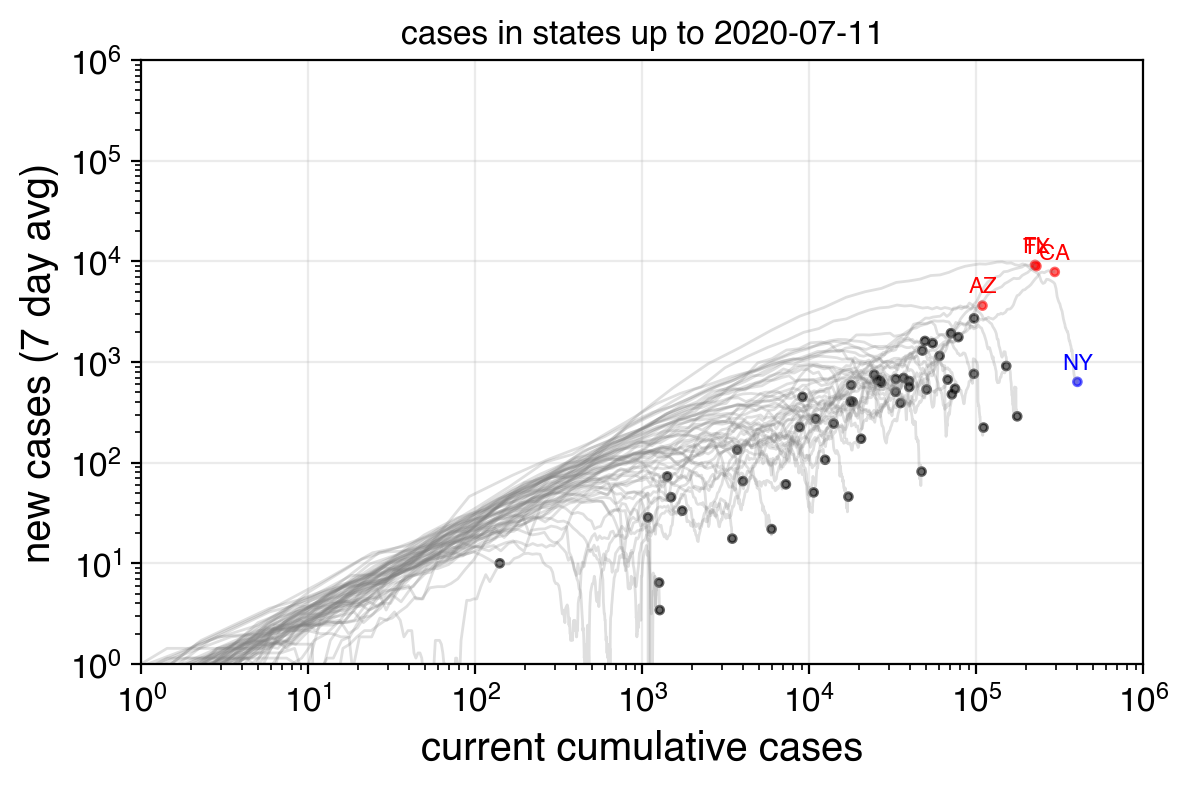

In [16]:
plot(max_date=max_date, regions="states", frac=1.0)
# plot(max_date=f"2020-05-03", regions="counties", frac=1.0)

In [17]:
!mkdir -p plot_trajectories/
!rm plot_trajectories/*.png

regions = "states"
# regions = "counties"

dates = pd.date_range("2020-02-12",max_date,freq="D").strftime("%Y-%m-%d")
for date in dates:
#     for frac in np.linspace(0,0.9,10):
    for frac in np.linspace(0,0.9,4):
        # frac 0 does the previous day, so we start with 0.0 to 0.9, then 
        # when i increments, it's the next day
        ifrac = int(frac*10)
        fname = f"plot_trajectories/plot_{date}_{ifrac}.png"
        print(fname)
        plot(max_date=date, frac=frac, regions=regions, fname=fname)


plot_trajectories/plot_2020-02-12_0.png
plot_trajectories/plot_2020-02-12_3.png
plot_trajectories/plot_2020-02-12_6.png
plot_trajectories/plot_2020-02-12_9.png
plot_trajectories/plot_2020-02-13_0.png
plot_trajectories/plot_2020-02-13_3.png
plot_trajectories/plot_2020-02-13_6.png
plot_trajectories/plot_2020-02-13_9.png
plot_trajectories/plot_2020-02-14_0.png
plot_trajectories/plot_2020-02-14_3.png
plot_trajectories/plot_2020-02-14_6.png
plot_trajectories/plot_2020-02-14_9.png
plot_trajectories/plot_2020-02-15_0.png
plot_trajectories/plot_2020-02-15_3.png
plot_trajectories/plot_2020-02-15_6.png
plot_trajectories/plot_2020-02-15_9.png
plot_trajectories/plot_2020-02-16_0.png
plot_trajectories/plot_2020-02-16_3.png
plot_trajectories/plot_2020-02-16_6.png
plot_trajectories/plot_2020-02-16_9.png
plot_trajectories/plot_2020-02-17_0.png
plot_trajectories/plot_2020-02-17_3.png
plot_trajectories/plot_2020-02-17_6.png
plot_trajectories/plot_2020-02-17_9.png
plot_trajectories/plot_2020-02-18_0.png


In [18]:
!ffmpeg -y -r 30 -f image2 -pattern_type glob -i 'plot_trajectories/*.png'  -vcodec libx264 -crf 15  -pix_fmt yuv420p trajectories_{regions}.mp4
!web trajectories_{regions}.mp4

ffmpeg version 4.1.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple LLVM version 10.0.0 (clang-1000.11.45.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.1.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/openjdk-11.0.2.jdk/Contents/Home/include/darwin' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-videotoolbox --disa

In [19]:
import time
time.sleep(2)

In [20]:
from IPython.display import HTML
HTML(f"""
    <video alt="test" controls autoplay>
        <source src="trajectories_{regions}.mp4" type="video/mp4">
    </video>
""")